<a href="https://colab.research.google.com/github/gregorywmorris/MLZoom2022/blob/main/midterm/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Auto-save / Auto-reload
%autosave 1

%load_ext autoreload
%autoreload 2

Autosaving every 1 seconds


# !pip

In [2]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.8 MB 1.2 MB/s 


In [3]:
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!pip install scipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
!pip install dask==2022.02.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
!pip install dataprep

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.5 MB 4.7 MB/s 
     |████████████████████████████████| 965 kB 64.2 MB/s 
     |████████████████████████████████| 1.0 MB 56.5 MB/s 
     |████████████████████████████████| 50 kB 6.1 MB/s 
     |████████████████████████████████| 101 kB 8.5 MB/s 
     |████████████████████████████████| 943 kB 28.2 MB/s 
     |████████████████████████████████| 133 kB 52.8 MB/s 
     |████████████████████████████████| 749 kB 42.1 MB/s 
     |████████████████████████████████| 78 kB 3.7 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 28.5 MB 6.8 MB/s 
     |████████████████████████████████| 96 kB 5.9 MB/s 
     |████████████████████████████████| 232 kB 37.3 MB/s 
     |████████████████████████████████| 1.6 MB 50.9 MB/s 
     |███████████████████████

# Imports

In [7]:
# for EDA
import pylab
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import ttest_ind
import scipy
import scipy.sparse as sparse 
from scipy.sparse import csr_matrix
import scipy.sparse.linalg as sla# needed for dataprep
from dataprep.eda import create_report

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot as skplt # https://scikit-plot.readthedocs.io/en/stable/Quickstart.htm

# for the models
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.impute import KNNImputer
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import ComplementNB

# metrics
from sklearn.metrics import accuracy_score, classification_report, roc_curve, precision_recall_curve, auc, confusion_matrix, roc_auc_score
from sklearn.metrics import mean_squared_error as rmse
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score


# Project Deliverables

**For a project, you repository/folder should contain the following:**

* `README.md` with
  * Description of the problem
  * Instructions on how to run the project
* Data
  * You should either commit the dataset you used or have clear instructions how to download the dataset
* Notebook (suggested name - `notebook.ipynb`) with
  * Data preparation and data clearning
  * EDA, feature importance analysis
  * Model selection process and parameter tuning
* Script train.py (suggested name)
  * Training the final model
  * Saving it to a file (e.g. pickle) or saving it with specialized software (BentoML)
* Script `predict.py` (suggested name)
  * Loading the model
  * Serving it via a web serice (with Flask or specialized sofware - BentoML, KServe, etc)
* Files with dependencies
  * `Pipenv` and `Pipenv.lock` if you use Pipenv
  * `bentofile.yaml` if you use BentoML
  * or equivalents: conda environment file, requirements.txt or pyproject.toml
* `Dockerfile` for running the service
* Deployment
  * URL to the service you deployed or
  * Video or image of how you interact with the deployed service





# Notebook Index

* [Problem Statement](#problem)
* [Data Selection](#data_about)
  * [Data Extraction](#extraction)
* [Initial EDA](#init_eda)
* [Model Baseline](#baseline)
* [Tuning](#tuning)
* [Deployment](#deploy)

<a name="problem"></a>
# Why Predicting Stroke Likelihood Matters





### By the Numbers
**Global**

Strokes are a global epidemic. They are the second leading cause of death and have increased by 70% between 1990 to 2019, with death from strokes inceasing by 43% ([source](https://www.thelancet.com/journals/laneur/article/PIIS1474-4422(21)00252-0/fulltext)). The WHO estimates the anual cost of strokes to be over US$721 billion ([source](https://pubmed.ncbi.nlm.nih.gov/34986727/#:~:text=Abstract,%25%20of%20the%20global%20GDP)).

**United States**

While strokes have been declining for decades in the US, it still has a large financial burden, amounting to $53 billion anually ([source](https://www.cdc.gov/stroke/facts.htm)). Currently stroke is the 5th leading cause of death in the US ([source](https://www.cdc.gov/nchs/fastats/leading-causes-of-death.htm)).

### Optimal Outcomes
**Global**

Predicting stroke can provide an opportunity to take corrective actions before a stroke occurs. Most importantly, resulting in fewer deaths and disabilities.

Addtionally, the money lost to strokes would boost econamies. Assuming cost and stroke occurance are linear, if strokes were reduced by just 5%, that would inject $36 billion into world economies.

**United States**

And $2.65 billion into the US econamy.

<a name="about_data"></a>
# Stroke Data

### An Appropriate Dataset
A seach for various stroke datasets that included health factors showed that the [Kaggle dataset](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset) was best suited. Numerous other stroke datasets are avaialbe but the lacked health factors needed. Datasets were often location based or even post stroke images. Neither are well suited for the the desired task.

### Limitations

* It is known that there are more factors for stroke prediction (such as [lab tests](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8686476/), lifestyle, etc.) than are avaialble in this data set.
  * However, [the most important factors](https://www.sciencedirect.com/science/article/pii/S2772442522000090) are in the dataset
* This data set was uploaded 2 years ago with no expectations of being updated.
* The source and accuracy to the data is unkown, a verified healthcare organization would be an ideal source for stroke data.

# Extract-Load-Transform (ELT)

#### The Process


**Extract:** Data is extracted from [Kaggle](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset) to [GitHub](https://github.com/gregorywmorris/MLZoom2022/blob/main/midterm/healthcare-dataset-stroke-data.csvhttps://github.com/gregorywmorris/MLZoom2022/blob/main/midterm/healthcare-dataset-stroke-data.csv)

**Load:** Data is loaded to the notebook

**Transform:** Data is modified to suit and improve the model

<a name="extraction"></a>
### Load

In [8]:
data = 'https://raw.githubusercontent.com/gregorywmorris/MLZoom2022/main/midterm/healthcare-dataset-stroke-data.csv'

In [9]:
!wget $data -O data.csv

--2022-10-31 15:30:52--  https://raw.githubusercontent.com/gregorywmorris/MLZoom2022/main/midterm/healthcare-dataset-stroke-data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 316971 (310K) [text/plain]
Saving to: ‘data.csv’

data.csv            100%[===================>] 309.54K  --.-KB/s    in 0.03s   

2022-10-31 15:30:52 (9.21 MB/s) - ‘data.csv’ saved [316971/316971]



In [10]:
df = pd.read_csv('data.csv')

<a name="init_eda"></a>
### Transform - Exploritory Data Analysis (EDA)

##### [Dataprep](https://docs.dataprep.ai/user_guide/clean/introduction.html)

DataPrep Report
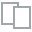
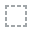
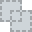
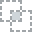
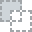
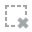
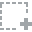
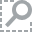
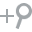
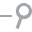
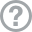
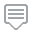
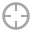
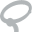
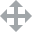
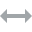
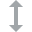
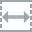
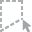
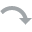
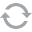
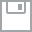
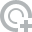
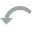
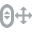
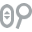
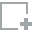
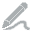
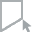
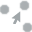
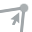
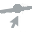

In [11]:
create_report(df)

**Report Summary:**
* bmi has 201 missing values
* No zero values (except where binary)
* Feature distributions are skewed
* Mix of numerical and catigorical features
* Low feature correlation

##### **Overview**

In [12]:
df.head(3)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1


In [13]:
#@title Drop column 'id'
df = df.drop(columns='id')

In [14]:
#@title Column names are need to be normalized to all lower case
col = df.columns.tolist() # list with new column names all lower case
df = df.rename(str.lower, axis='columns')

In [15]:
#@title data Overview
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


In [16]:
#@title statistical overview, look for outliers or oddities
df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


Min age of 0.08, expected whole integers.

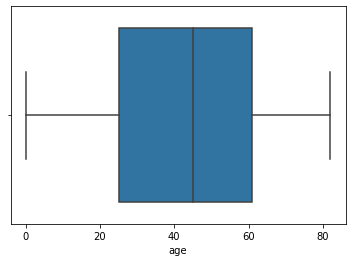

In [17]:
#@title No outliers in age
sns.boxplot(x=df.age)

In [18]:
#@title Distribution of all features are all highly possitivley skewed except for age which is slightly negatively skewed.
df.skew(numeric_only=True) # numeric_only=True else error

age                 -0.137059
hypertension         2.715392
heart_disease        3.947244
avg_glucose_level    1.572284
bmi                  1.055340
stroke               4.193284
dtype: float64

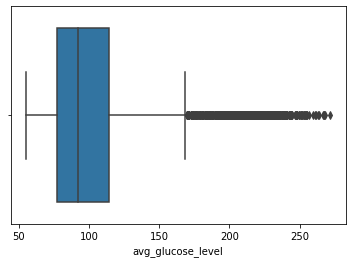

In [19]:
#@title Outliers noted in df.avg_glucose_level
sns.boxplot(x=df.avg_glucose_level)

In [20]:
df.avg_glucose_level.max()

271.74

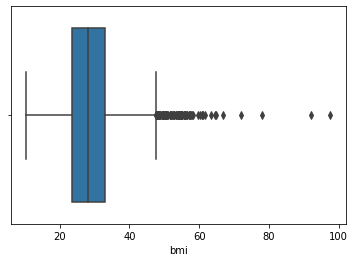

In [21]:
#@title Outliers noted in df.bmi
sns.boxplot(x=df.bmi)

In [22]:
df.bmi.max()

97.6

##### **Label Value - df.stroke**

The target value to be predicted is df.stroke. This a a binary feature with 1 to indicate possitive for stroke and 0 to indicate not possitive for stroke.

In [23]:
df.stroke.value_counts()

0    4861
1     249
Name: stroke, dtype: int64

High imbalance with a low value count for the possitive prediction. 

The label data is imbalanced, this is consistent with expectations as more people don't have stroke than do. Further consideration should be done on the negative affect this may have on the models. [Possible solutions](https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/).

##### **df.age**

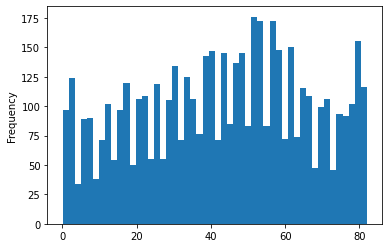

In [24]:
df.age.plot.hist(bins=50)

In [25]:
df.age.value_counts()

78.00    102
57.00     95
52.00     90
54.00     87
51.00     86
        ... 
1.40       3
0.48       3
0.16       3
0.40       2
0.08       2
Name: age, Length: 104, dtype: int64

Clarification on age [here](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset/discussion/223242?search=age), decimal places represent days. 

##### **df.bmi**

###### **Missing values**
[Missing Value Guide](https://www.analyticsvidhya.com/blog/2021/10/handling-missing-value/)
Fill missing values based on groups of either possitive for stroke or not. Suspect possible difference in grouping.

In [26]:
stroke_bmi_0, stroke_bmi_1 =df.groupby('stroke')['bmi'].mean()
stroke_bmi_0, stroke_bmi_1 # 0 not a stroke and 1 is a stroke

(28.823063829787234, 30.471291866028707)

In [27]:
round((stroke_bmi_1-stroke_bmi_0)/stroke_bmi_1,2)

0.05

Slight variance of 5% in bmi mean, note dtype is float64

Review the distribution of bmi as a total and by stroke value

((array([-3.6412931, -3.4063133, -3.2768215, ...,  3.2768215,  3.4063133,
          3.6412931]), array([10.3, 11.3, 11.5, ...,  nan,  nan,  nan])),
 (nan, nan, nan))

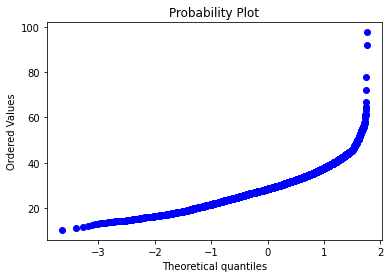

In [28]:
stats.probplot(df.bmi,fit=True, plot=pylab )

The probability plot shows that the bmi distribution is not normal. Next step is to see if the distribution can be transformed to a normal distribuion for a p-value analysis.

**Normalize df.bmi Distribution**

Distribution can be normalized well enough to calculate a p-value.

[Normalization techniques](https://www.analyticsvidhya.com/blog/2021/05/how-to-transform-features-into-normal-gaussian-distribution/)

In [29]:
def normality(data,feature):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    sns.kdeplot(data[feature])
    plt.subplot(1,2,2)
    stats.probplot(data[feature],plot=pylab)
    plt.show()

In [30]:
df_cp = df.copy() #must reimport data if this is ran after changes are made.

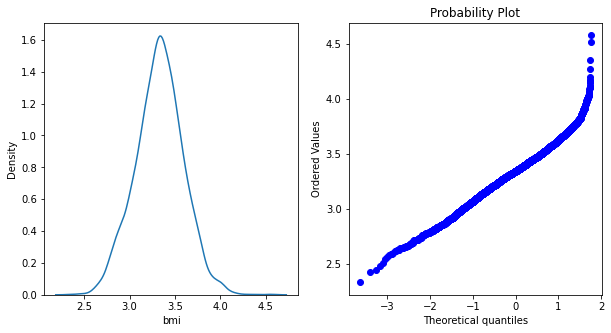

0.0011326087933981655

In [31]:
#performing logarithmic transformation on the feature
df_bmi = df_cp.copy()
df_bmi.bmi=np.log(df.bmi)
normality(df_bmi,'bmi')
df_bmi.bmi.skew()

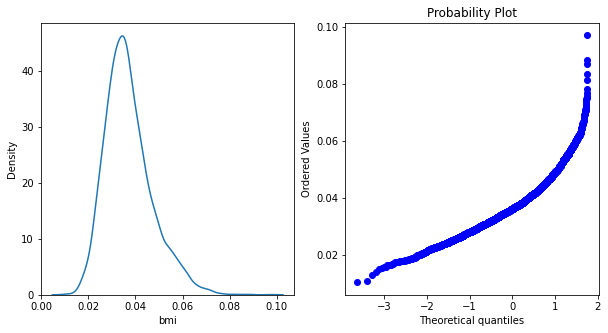

0.8591866889536662

In [32]:
#Reciprocal Transformation
df_bmi = df_cp.copy()
df_bmi.bmi=1/df_bmi.bmi
normality(df_bmi,'bmi')
df_bmi.bmi.skew()

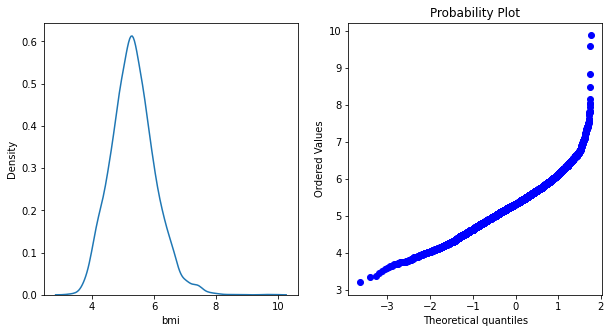

0.4748565689090631

In [33]:
#Square Root Transformation
df_bmi = df_cp.copy()
df_bmi.bmi=np.sqrt(df_bmi.bmi)
normality(df_bmi,'bmi')
df_bmi.bmi.skew()

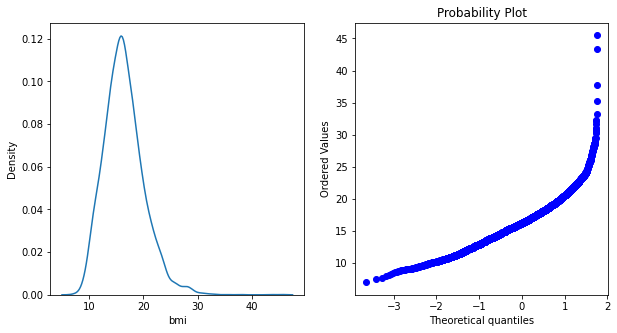

0.8439381127696062

In [34]:
#Exponential Transformation
df_bmi = df_cp.copy()
df_bmi.bmi=df.bmi**(1/1.2)
normality(df_bmi, 'bmi')
df_bmi.bmi.skew()

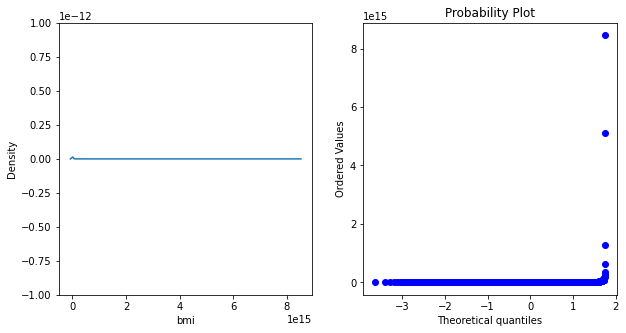

51.59532132895192

In [35]:
#Box-Cox Transformation
df_bmi = df_cp.copy()
df_bmi.bmi,parameters=stats.boxcox(df_bmi.bmi)
normality(df_bmi,'bmi')
df_bmi.bmi.skew()

**p-value**
The two sample test shows that the difference in the bmi distributions are NOT statistiacally signifigant. Replacing the missing values with the overall mean is justified.

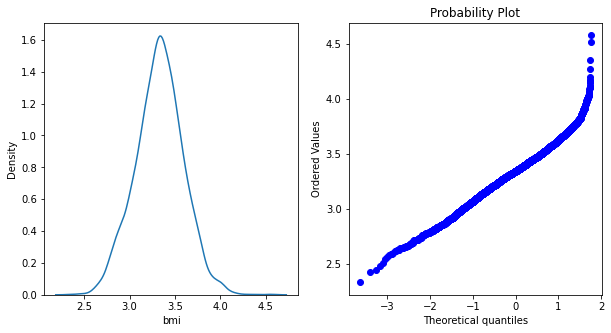

0.0011326087933981655

In [36]:
df_bmi = df.copy()
df_bmi.bmi=np.log(df.bmi)
normality(df_bmi,'bmi')
df_bmi.bmi.skew()

The distribution is very close to normal, only off by 0.001

stroke
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: bmi, dtype: object

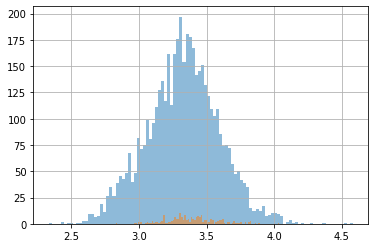

In [37]:
df_bmi.groupby('stroke')['bmi'].hist(bins=100, alpha=0.5)

In [38]:
bmi_stroke_0, bmi_stroke_1 =df_bmi.groupby('stroke')['bmi']

In [39]:
# one sample
stats.ttest_1samp(a=bmi_stroke_1[1],popmean=bmi_stroke_0[0], nan_policy='omit')

Ttest_1sampResult(statistic=244.833779465847, pvalue=6.025963176549174e-258)

The  one sample test shows that the difference in the bmi distributions are **NOT** statistiacally signifigant. Replacing the missing values with the overall median is justified. I chose median due the current outliers affecting the mean.

**Fill Missing Values**

In [40]:
df.bmi = df.bmi.fillna(df.bmi.median())

###### **Manage Outliers**

[Outliers Guide](https://www.analyticsvidhya.com/blog/2021/05/detecting-and-treating-outliers-treating-the-odd-one-out/) 

In [41]:
df.bmi.value_counts(bins=15)

(27.76, 33.58]     1596
(21.94, 27.76]     1501
(16.12, 21.94]      774
(33.58, 39.4]       690
(39.4, 45.22]       299
(10.212, 16.12]     100
(45.22, 51.04]       86
(51.04, 56.86]       43
(56.86, 62.68]       13
(62.68, 68.5]         4
(91.78, 97.6]         2
(68.5, 74.32]         1
(74.32, 80.14]        1
(80.14, 85.96]        0
(85.96, 91.78]        0
Name: bmi, dtype: int64

In [42]:
# Computing 10th, 90th percentiles and replacing the outliers
tenth_percentile = np.percentile(df.bmi, 10)
ninetieth_percentile = np.percentile(df.bmi, 90)
# print(tenth_percentile, ninetieth_percentile)b = np.where(df.bmi<tenth_percentile, tenth_percentile, df.bmi)
df.bmi = np.where(df.bmi>ninetieth_percentile, ninetieth_percentile,df.bmi)


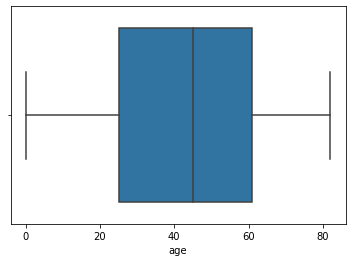

In [43]:
sns.boxplot(x=df.age)

While the bmi values are outside the expeted range they are within norm for humans. Withou a height, it is not possible to know if the values are inaccurate, [BMI Chart](https://www.nhlbi.nih.gov/health/educational/lose_wt/BMI/bmi_tbl.pdf). 

However, the low number of values means we can't make accurate predctions. I have decided to constrain the data between 10th and 90th percentile to improve model predictions.




##### **df.avg_glucose_level**

###### **P-value avg_glucose_level**

Reseach shows that Categorizing to above and below a bloodsugar limit may improve predictions.

 [Cleavland Clinic](https://my.clevelandclinic.org/health/diseases/9812-diabetes-and-stroke#:~:text=Your%20body%20can't%20make,Extra%20body%20weight.), [AHA Journal](https://www.ahajournals.org/doi/full/10.1161/01.str.0000115297.92132.84), [stroke.org.uk](https://www.stroke.org.uk/what-is-stroke/are-you-at-risk-of-stroke/diabetes), [Stroke.org - Diabetes](https://www.stroke.org/en/about-stroke/stroke-risk-factors/diabetes-and-stroke-prevention). 

In [44]:
stroke_glucose_0, stroke_glucose_1 =df.groupby('stroke')['avg_glucose_level'].mean()
stroke_glucose_0, stroke_glucose_1 # 0 not a stroke and 1 is a stroke

(104.79551326887471, 132.54473895582328)

In [45]:
round((stroke_glucose_1-stroke_glucose_0)/stroke_glucose_1,2)

0.21

A small variance in the mean of avg_glucose_level of 18%.

In [46]:
# stroke negative
stroke_gluc_0, stroke_gluc_1 =df.groupby('stroke')['avg_glucose_level']
stroke_gluc_0[1].describe()

count    4861.000000
mean      104.795513
std        43.846069
min        55.120000
25%        77.120000
50%        91.470000
75%       112.830000
max       267.760000
Name: avg_glucose_level, dtype: float64

In [47]:
# stroke possitive
stroke_gluc_1[1].describe()

count    249.000000
mean     132.544739
std       61.921056
min       56.110000
25%       79.790000
50%      105.220000
75%      196.710000
max      271.740000
Name: avg_glucose_level, dtype: float64

###### **Normallize avg_glucose_level**

((array([-3.6412931, -3.4063133, -3.2768215, ...,  3.2768215,  3.4063133,
          3.6412931]),
  array([ 55.12,  55.22,  55.23, ..., 267.61, 267.76, 271.74])),
 (40.678945925100635, 106.1476771037182, 0.8978160806829297))

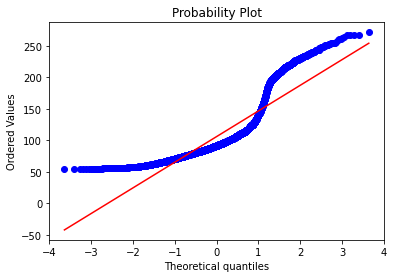

In [48]:
stats.probplot(df.avg_glucose_level,fit=True, plot=pylab )

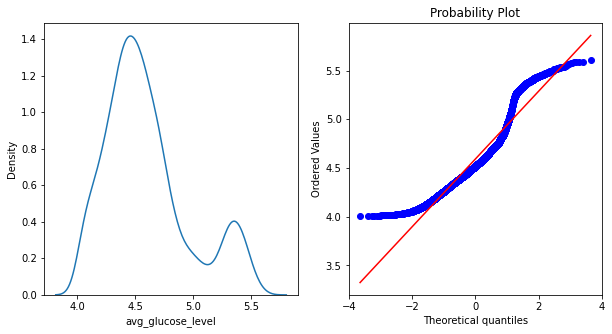

0.8827511014266456

In [49]:
#performing logarithmic transformation on the feature
df2 = df.copy()
df2.avg_glucose_level=np.log(df.avg_glucose_level)
normality(df2,'avg_glucose_level')
df2.avg_glucose_level.skew()

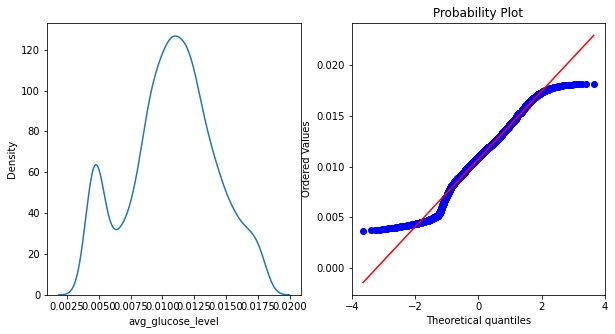

-0.12577378741588255

In [50]:
#Reciprocal Transformation
df2 = df_cp.copy()
df2.avg_glucose_level=1/df2.avg_glucose_level
normality(df2,'avg_glucose_level')
df2.avg_glucose_level.skew()

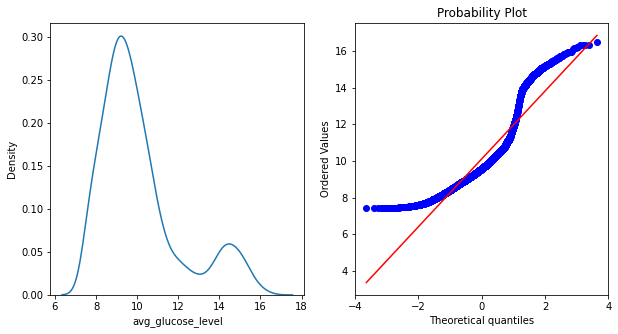

1.2427218676251186

In [51]:
#Square Root Transformation
df2 = df_cp.copy()
df2.avg_glucose_level=np.sqrt(df2.avg_glucose_level)
normality(df2,'avg_glucose_level')
df2.avg_glucose_level.skew()

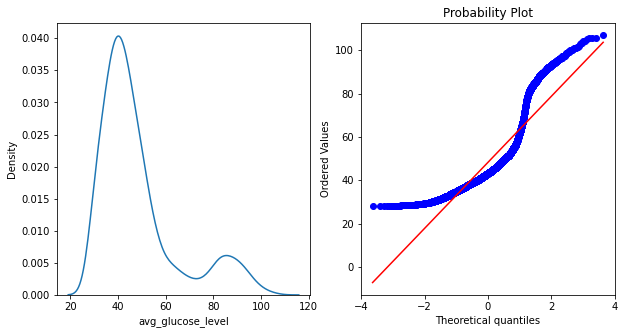

1.4662829646834146

In [52]:
#Exponential Transformation
df2 = df_cp.copy()
df2.avg_glucose_level=df.avg_glucose_level**(1/1.2)
normality(df2, 'avg_glucose_level')
df2.avg_glucose_level.skew()

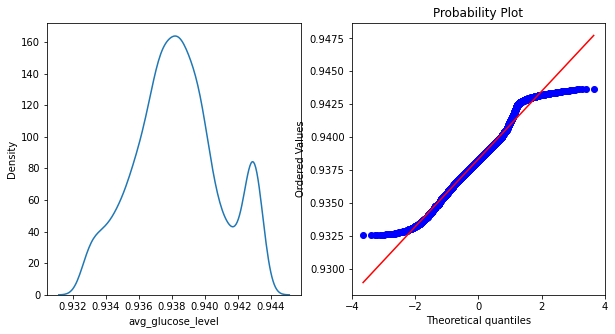

0.08329904162034814

In [53]:
#Box-Cox Transformation
df2 = df_cp.copy()
df2.avg_glucose_level,parameters=stats.boxcox(df2.avg_glucose_level)
normality(df2,'avg_glucose_level')
df2.avg_glucose_level.skew()

###### **Final Decision**

* Unable to normalize the distribution avg_glucose_level
* Unable to get reliable p-value due to distribution

Despite research indicating a clear delineation with high blood sugar and stroke, I am not able to confirm that with the current understanding of the relationship from this data. No justification for categorizing avg_glucose_level based on reported glucose ranges should be done without further external reseach or more data.

###### **Outliers avg_glucose_level**

In [54]:
df['avg_glucose_level'].max()

271.74

In [55]:
df['avg_glucose_level'].min()

55.12

In [56]:
df.avg_glucose_level.value_counts(bins=15)

(69.561, 84.003]      1170
(84.003, 98.444]      1142
(98.444, 112.885]      746
(54.902, 69.561]       728
(112.885, 127.327]     370
(199.533, 213.975]     162
(127.327, 141.768]     150
(213.975, 228.416]     145
(185.092, 199.533]     119
(141.768, 156.209]     113
(228.416, 242.857]      88
(156.209, 170.651]      71
(170.651, 185.092]      61
(242.857, 257.299]      35
(257.299, 271.74]       10
Name: avg_glucose_level, dtype: int64

While the glucose outliers may be out of hte normal range they are not abnormal as conditions such diabetes are reasonable cause for such numbers.

Just as bmi the the higher range is too low of a value count and we must again constrain the data. Again using the 90th percentile as the upper limit.

In [57]:
# Computing 90th percentiles and replacing the outliers
ninetieth_percentile = np.percentile(df.avg_glucose_level, 90)
# print(tenth_percentile, ninetieth_percentile)b = np.where(df.avg_glucose_level<tenth_percentile, tenth_percentile, df.avg_glucose_level)
df.avg_glucose_level = np.where(df.avg_glucose_level>ninetieth_percentile, ninetieth_percentile,df.avg_glucose_level)

In [58]:
df.avg_glucose_level.value_counts(bins=15)

(82.532, 91.67]       775
(73.395, 82.532]      774
(91.67, 100.807]      639
(64.257, 73.395]      568
(183.044, 192.181]    568
(100.807, 109.944]    460
(54.982, 64.257]      420
(109.944, 119.082]    339
(119.082, 128.219]    189
(128.219, 137.357]    101
(137.357, 146.494]     89
(146.494, 155.631]     63
(155.631, 164.769]     48
(173.906, 183.044]     41
(164.769, 173.906]     36
Name: avg_glucose_level, dtype: int64

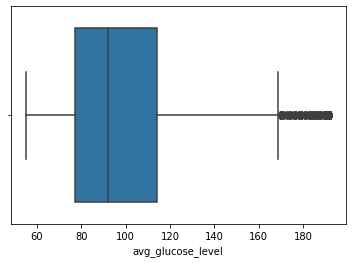

In [59]:
# Post processing
sns.boxplot(x=df['avg_glucose_level'])

In [60]:
df['avg_glucose_level'].max()

192.18100000000007

##### **df.residence_type**

In [61]:
rt = df.residence_type.value_counts().copy()
rt

Urban    2596
Rural    2514
Name: residence_type, dtype: int64

In [62]:
df.residence_type = (df.residence_type == 'Urban').astype(int)
df.residence_type.value_counts()

1    2596
0    2514
Name: residence_type, dtype: int64

##### **df.ever_married**

In [63]:
em = df.ever_married.value_counts()
em

Yes    3353
No     1757
Name: ever_married, dtype: int64

In [64]:
# convert Yes and No to 1 and 0.
df.ever_married = (df.ever_married == 'Yes').astype(int)
df.ever_married.value_counts()

1    3353
0    1757
Name: ever_married, dtype: int64

##### **Multi-categories** pd.dummies for further anlysis

In [65]:
df2 = df.copy()

###### **df2.gender**

In [66]:
gender = df2.gender.value_counts().copy()
gender

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

In [67]:
dummies = pd.get_dummies(df2.gender)
df2 = pd.concat([df2, dummies],axis='columns')
del df2['gender'] # drop gender
df2.columns

Index(['age', 'hypertension', 'heart_disease', 'ever_married', 'work_type',
       'residence_type', 'avg_glucose_level', 'bmi', 'smoking_status',
       'stroke', 'Female', 'Male', 'Other'],
      dtype='object')

###### **df2.work_type**

In [68]:
wt = df2.work_type.value_counts().copy()
wt

Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64

In [69]:
dummies = pd.get_dummies(df2.work_type)
df2 = pd.concat([df2, dummies],axis='columns')
del df2['work_type']
df2.columns

Index(['age', 'hypertension', 'heart_disease', 'ever_married',
       'residence_type', 'avg_glucose_level', 'bmi', 'smoking_status',
       'stroke', 'Female', 'Male', 'Other', 'Govt_job', 'Never_worked',
       'Private', 'Self-employed', 'children'],
      dtype='object')

###### **df2.smoking_status**

In [70]:
ss = df2.smoking_status.value_counts().copy()
ss

never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64

In [71]:
dummies = pd.get_dummies(df2.smoking_status)
df2 = pd.concat([df2, dummies],axis='columns')
del df2['smoking_status']
df2.columns

Index(['age', 'hypertension', 'heart_disease', 'ever_married',
       'residence_type', 'avg_glucose_level', 'bmi', 'stroke', 'Female',
       'Male', 'Other', 'Govt_job', 'Never_worked', 'Private', 'Self-employed',
       'children', 'Unknown', 'formerly smoked', 'never smoked', 'smokes'],
      dtype='object')

##### **Final Feature Overview**

###### df2 - pd.dummies

In [72]:
# convert new column names to lower
col = df2.columns.tolist()
df2 = df2.rename(str.lower, axis='columns')
col = df2.columns.tolist() # list with new column names all lower case


In [73]:
# confirm column names and dtypes
df2.dtypes

age                  float64
hypertension           int64
heart_disease          int64
ever_married           int64
residence_type         int64
avg_glucose_level    float64
bmi                  float64
stroke                 int64
female                 uint8
male                   uint8
other                  uint8
govt_job               uint8
never_worked           uint8
private                uint8
self-employed          uint8
children               uint8
unknown                uint8
formerly smoked        uint8
never smoked           uint8
smokes                 uint8
dtype: object

Dummy columns may lose context once separated. Renaming columns would make the data more readable. Addionally the name word spacing should use '_' rather than ' ' or '-'.

In [74]:
df2 = df2.rename(columns={'other': 'other_gender','formerly smoked':'formerly_smoked','never smoked':'never_smoked','unknown':'unknown_smoking','children': 'is_a_child','private': 'employed','self-employed':'self_employed' })

In [75]:
# Confirm changes
df2.dtypes

age                  float64
hypertension           int64
heart_disease          int64
ever_married           int64
residence_type         int64
avg_glucose_level    float64
bmi                  float64
stroke                 int64
female                 uint8
male                   uint8
other_gender           uint8
govt_job               uint8
never_worked           uint8
employed               uint8
self_employed          uint8
is_a_child             uint8
unknown_smoking        uint8
formerly_smoked        uint8
never_smoked           uint8
smokes                 uint8
dtype: object

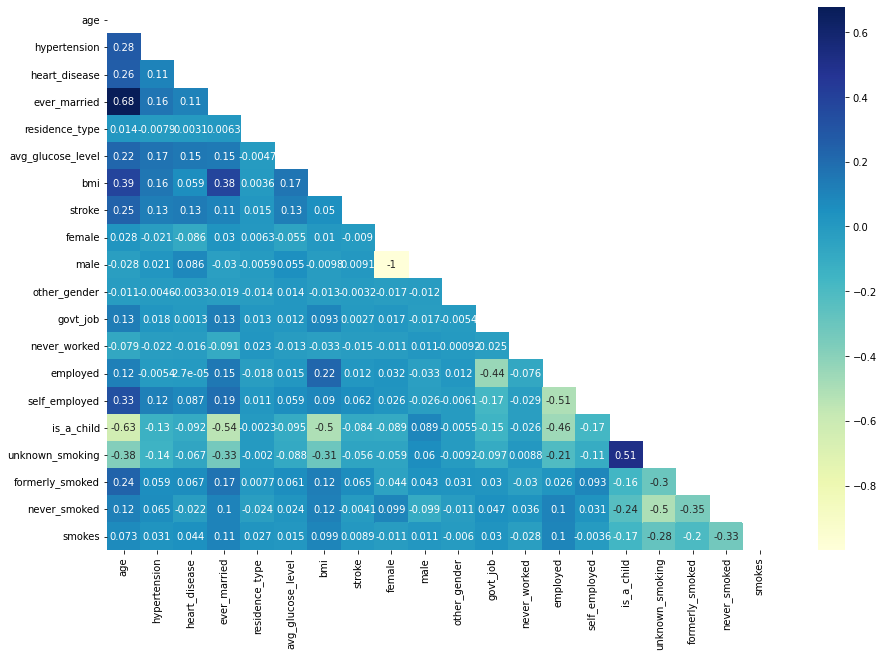

In [76]:
# Review feature correlation, consider action for highly correlated features.
plt.subplots(figsize=(15,10))

mask = np.triu(np.ones_like(df2.corr())) # triangle mask to hide duplicates

sns.heatmap(df2.corr(),cmap="YlGnBu", annot=True, mask=mask)

None of the independant features have a high (0.75+) correlation that may skew models. All feature have a low (< 0.50) to moderate (0.50 >< 0.75) correlation. 

The exception is that a high correlation with the label / predictive value (stroke) is optimal. None of the values have a high correlation with this feature. Unsurpsiingly bmi has the highest correlation at 0.25. is_a_child has a negative correlation at -0.089, lower than expected.

Note: High correlation is acceptable for dependant features. There are no dependant variables in the above graph.

In [77]:
df2.corr()['stroke'].sort_values(ascending=False).iloc[1:]

age                  0.245257
heart_disease        0.134914
hypertension         0.127904
avg_glucose_level    0.125494
ever_married         0.108340
formerly_smoked      0.064556
self_employed        0.062168
bmi                  0.049833
residence_type       0.015458
employed             0.011888
male                 0.009117
smokes               0.008939
govt_job             0.002677
other_gender        -0.003166
never_smoked        -0.004129
female              -0.009027
never_worked        -0.014882
unknown_smoking     -0.055892
is_a_child          -0.083869
Name: stroke, dtype: float64

Feature - stroke correlation, the top 4 correlated features are consistent with expected highs correlations. Unexpected is 'ever_married' being slightly higher than 'formerly_smoked'.

In [78]:
df2.skew()

age                  -0.137059
hypertension          2.715392
heart_disease         3.947244
ever_married         -0.657745
residence_type       -0.032107
avg_glucose_level     1.227192
bmi                  -0.008842
stroke                4.193284
female               -0.348930
male                  0.349749
other_gender         71.484264
govt_job              2.219958
never_worked         15.146344
employed             -0.292800
self_employed         1.852619
is_a_child            2.143866
unknown_smoking       0.861974
formerly_smoked       1.727782
never_smoked          0.537548
smokes                1.913452
dtype: float64

Much of the data is far from a Gaussian (normal) distribution. This will negatively affect model performance and is likely due to the sampling of data made avaiable on Kaggle. Consider [QuantileTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html#sklearn.preprocessing.QuantileTransformer) and [PowerTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html#sklearn.preprocessing.PowerTransformer).

<a name="baseline"></a>
# Modeling

The modeling proccess is to first test possable viable models, then select the best models, and create a baseline to compare the tuning process against. 

**Linear Regression** is a poor choice for clasification output problems and better suited for continuous output problems. While the label is binary the model could provide values outside of that range.

Researching ML models and the general concesses from ML engineers show the following models best for our label which is a binary classifier (stroke 1 or 0). There are numerous articles and research papers but this [article](https://towardsdatascience.com/pros-and-cons-of-various-classification-ml-algorithms-3b5bfb3c87d6) and this [article](https://towardsdatascience.com/top-10-binary-classification-algorithms-a-beginners-guide-feeacbd7a3e2) sum up the reasoning.

In [95]:
#@title def model_run(models)
def model_run(models):
  models_score = []
  for name, model in models:
      model = model
      model.fit(x_train, y_train)
      model.predict(x_test)
      models_score.append([name, accuracy_score(y_test, model.predict(x_test))])
      
      print(" ")
      print("Model: ",name)
      print('Validation Accuracy: ', accuracy_score(y_test, model.predict(x_test)))
      print('Training Accuracy: ', accuracy_score(y_train, model.predict(x_train)))
      print(" ")
      
      plt.figure()
      cf_matrix = confusion_matrix(y_test, model.predict(x_test))
      plt.title('Confusion Matrix: {}'.format(name))
      sns.heatmap(cf_matrix, annot = True, fmt = 'g', cmap = sns.cubehelix_palette(as_cmap=True))
      plt.show()
      
      print(" ")

      skplt.metrics.plot_roc(y_test, model.predict_proba(x_test))
      plt.title('ROC Curves: {}'.format(name))
      plt.show()

### Data Prep

In [79]:
#@title Split: df_train / df_test

df_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)


y_train = df_train.stroke.values
y_test = df_test.stroke.values

del df_train['stroke']
del df_test['stroke']

In [80]:
#@title x_train
train_dict = df_train.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
x_train = dv.fit_transform(train_dict)



In [81]:
#@title x_test
test_dict = df_test.to_dict(orient='records')
x_test = dv.transform(test_dict)

In [82]:
#@title Train SMOTE - to address the stroke imbalance

# ONLY APPLY SMOTE TO TRAIN!

smt = SMOTE(random_state=1)

x_train, y_train = smt.fit_resample(x_train, y_train)


### Model Comparison

In [83]:
#@title Model Selection
models = [('Logistic Regression', LogisticRegression()),
          ('Decision Tree Classifier', DecisionTreeClassifier()),
          ('Random Forest', RandomForestClassifier()),
          ('Linear Discriminant Analyzer', LinearDiscriminantAnalysis()),
          ('Ada Boost', AdaBoostClassifier()),
          ('KNN', KNeighborsClassifier()),
          ('Support Vector Machine', SVC(probability = True)),
          ('XG Boost', XGBClassifier()),
          ('Cat Boost', CatBoostClassifier(logging_level = 'Silent')),
          ('Naive Bayes', ComplementNB())]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


 
Model:  Logistic Regression
Validation Accuracy:  0.7485322896281801
Training Accuracy:  0.7677609643498333
 


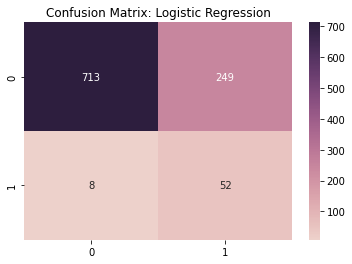

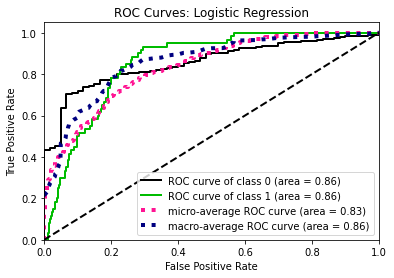

 
Model:  Decision Tree Classifier
Validation Accuracy:  0.8972602739726028
Training Accuracy:  1.0
 


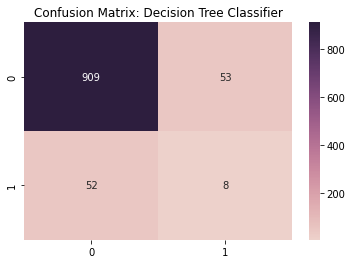

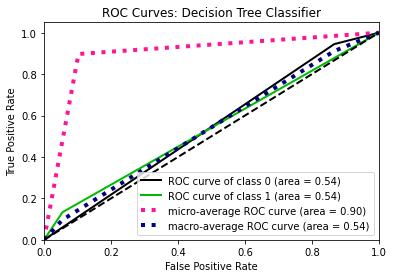

 
Model:  Random Forest
Validation Accuracy:  0.9363992172211351
Training Accuracy:  1.0
 


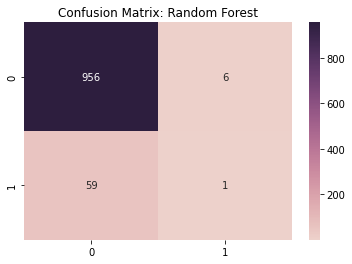

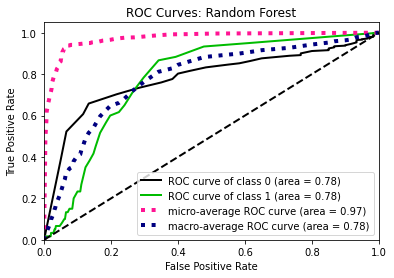

 
Model:  Linear Discriminant Analyzer
Validation Accuracy:  0.738747553816047
Training Accuracy:  0.7686586304180559
 


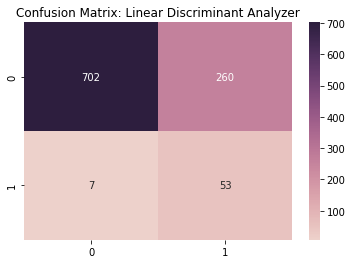

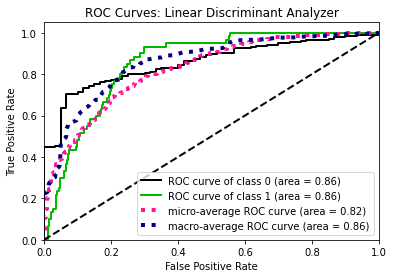

 
Model:  Ada Boost
Validation Accuracy:  0.9324853228962818
Training Accuracy:  0.9658886894075404
 


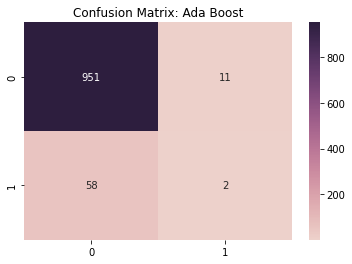

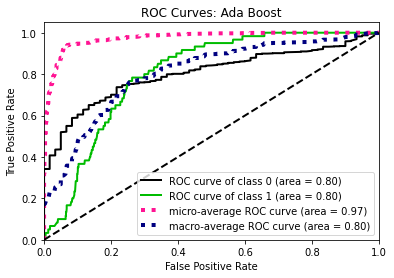

 
Model:  KNN
Validation Accuracy:  0.786692759295499
Training Accuracy:  0.9201077199281867
 


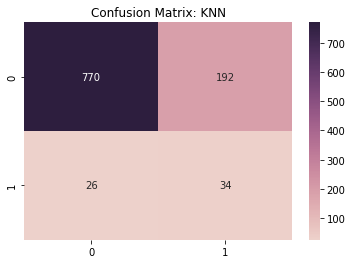

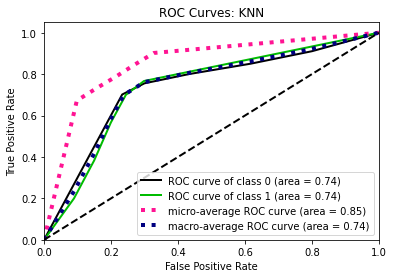

 
Model:  Support Vector Machine
Validation Accuracy:  0.7172211350293543
Training Accuracy:  0.7575019235701462
 


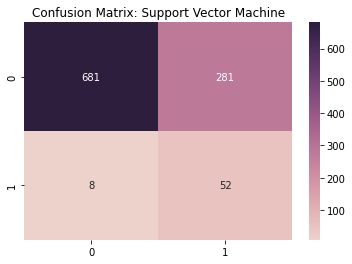

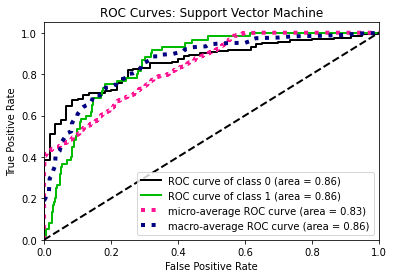

 
Model:  XG Boost
Validation Accuracy:  0.9412915851272016
Training Accuracy:  0.9726853039240831
 


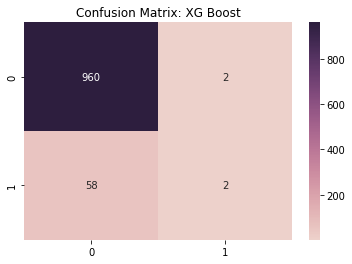

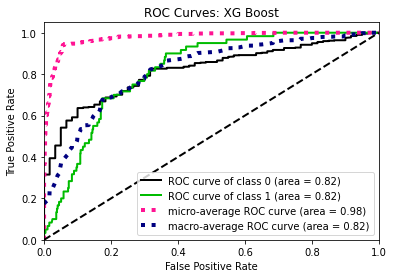

 
Model:  Cat Boost
Validation Accuracy:  0.9324853228962818
Training Accuracy:  0.9905103872787895
 


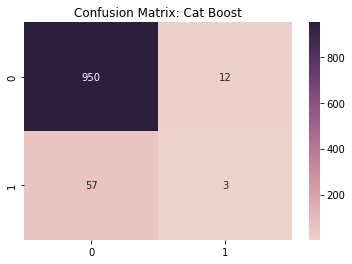

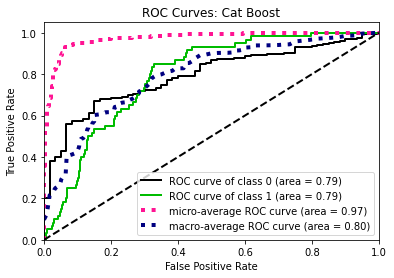

 
Model:  Naive Bayes
Validation Accuracy:  0.6565557729941291
Training Accuracy:  0.6887663503462427
 


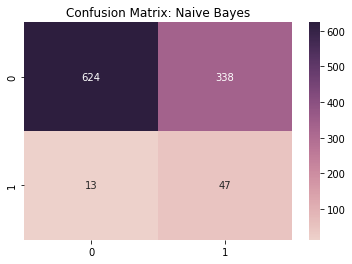

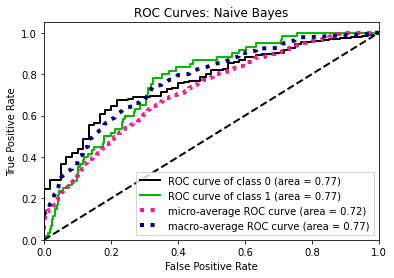

In [91]:
model_run(models)

Regarding [convergence error](https://stackoverflow.com/questions/62658215/convergencewarning-lbfgs-failed-to-converge-status-1-stop-total-no-of-iter)

### Best Performing Models

**While the score may not be the highest, these models were the best at predicting a stroke. The trade off is lower non-stroke accuracy. In the case of healthcare, we would rather capture non-stroke than miss actual strokes.**

In [92]:
#@title Selected Models
selected_models = [('Logistic Regression', LogisticRegression()),
          ('Linear Discriminant Analyzer', LinearDiscriminantAnalysis()),
          ('Support Vector Machine', SVC(probability = True))]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


 
Model:  Logistic Regression
Validation Accuracy:  0.7485322896281801
Training Accuracy:  0.7677609643498333
 


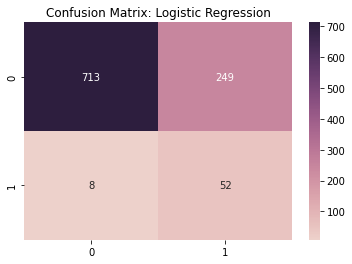

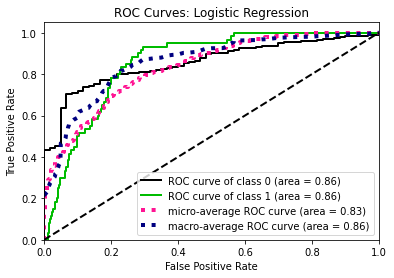

 
Model:  Linear Discriminant Analyzer
Validation Accuracy:  0.738747553816047
Training Accuracy:  0.7686586304180559
 


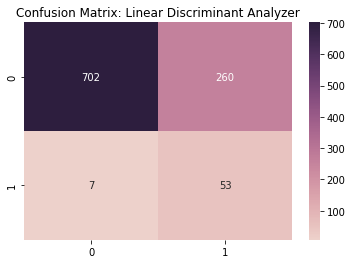

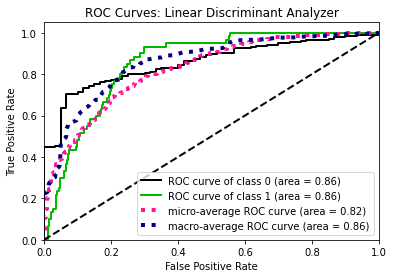

 
Model:  Support Vector Machine
Validation Accuracy:  0.7172211350293543
Training Accuracy:  0.7575019235701462
 


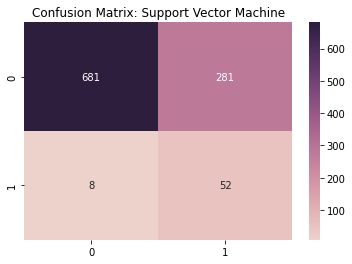

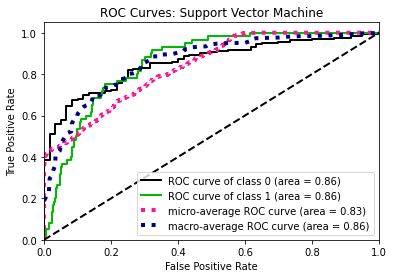

In [93]:
model_run(selected_models)

<a name="tuning"></a>
# Tuning

The tuning process consists of adjusting and measuring model parameters, and, if needed, revisiting feature engineering.

Overview of the models in the variable `selected_models`:

* **Logistic Regression**, `LogisticRegression()`
  * *Validation Accuracy:  0.7485322896281801*
  * *Training Accuracy:  0.7677609643498333*
* **Linear Discriminant Analyzer**, `LinearDiscriminantAnalysis()`
  * *validation Accuracy:  0.738747553816047*
  * *Training Accuracy:  0.7686586304180559*
* **Support Vector Machine**, `SVC(probability = True)`
  * *Validation Accuracy:  0.7172211350293543*
  * *Training Accuracy:  0.7575019235701462*

## Feature Importance - [article](https://towardsdatascience.com/understanding-feature-importance-and-how-to-implement-it-in-python-ff0287b20285#:~:text=Feature%20Importance%20refers%20to%20techniques,to%20predict%20a%20certain%20variable.)

<a name="deploy"></a>
# Deployment